# Webex Teams Client API Tutorial

The Webex APIs give you easy access to the Webex Platform to build Bots, Integrations, or Guest Issuer apps. We will work with Integrations in this Notebook. **To get started you need a WebEx Developer Account or browse to your session page, to get webex account information **.

### What is Integration?

Integrations are how you request permission to invoke the Webex REST API on behalf of another Webex user. For example, **User A** wants  some features such as a messaging platform for his/her website. WebEx Integrations will allow Developers to create that platform in WebEx and integrate it with **User A's** Website using **Integrations**. 

<br />

We will divide this **notebook** in three steps:

1. Create Integration.
2. Perform Authentication.
3. Develop a simple Application to send and recieve messages.

So Let's start

## 1. Create Integration

Please browse to **https://developer.webex.com/** and login by using the account details provided in your session page and then clicking on the top right. Once you have logged in to your Developer account, click on **My Webex Apps** as shown in Figure.

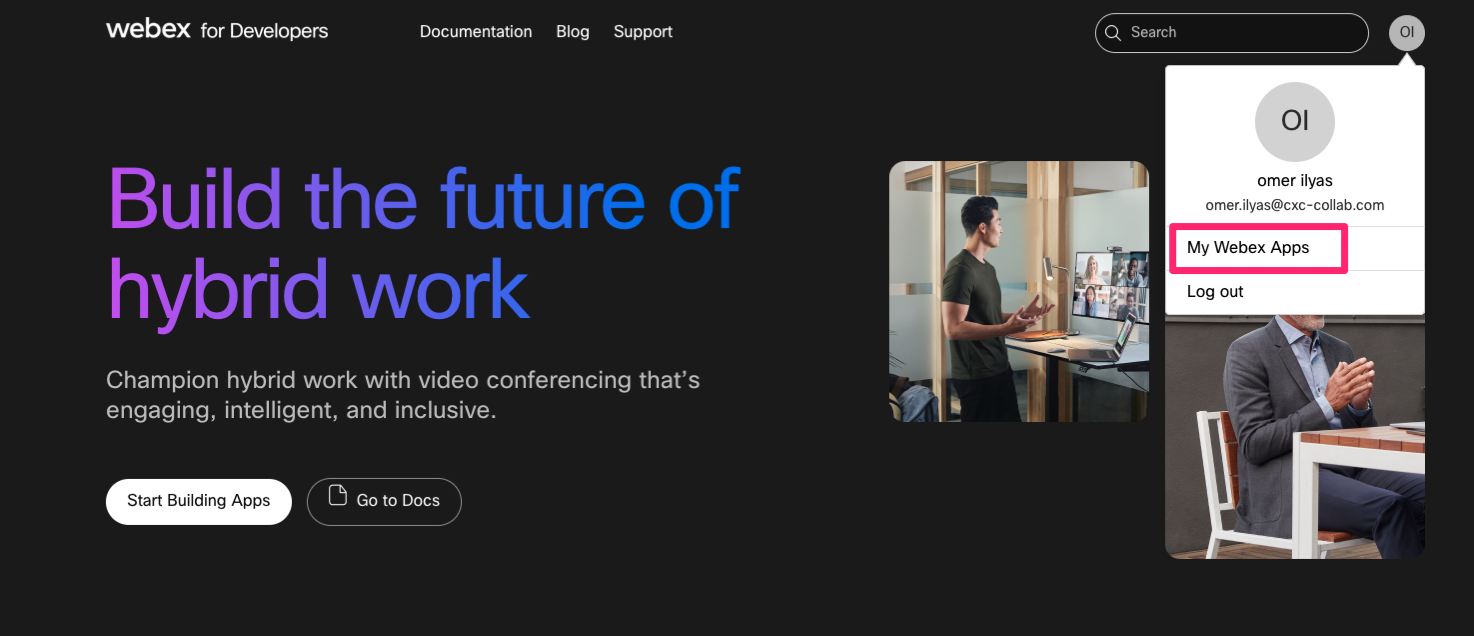

 This will prompt you to the Apps page. Currently you would have no App created . So lets start by creating one. Click on **"Create an Integration"**. 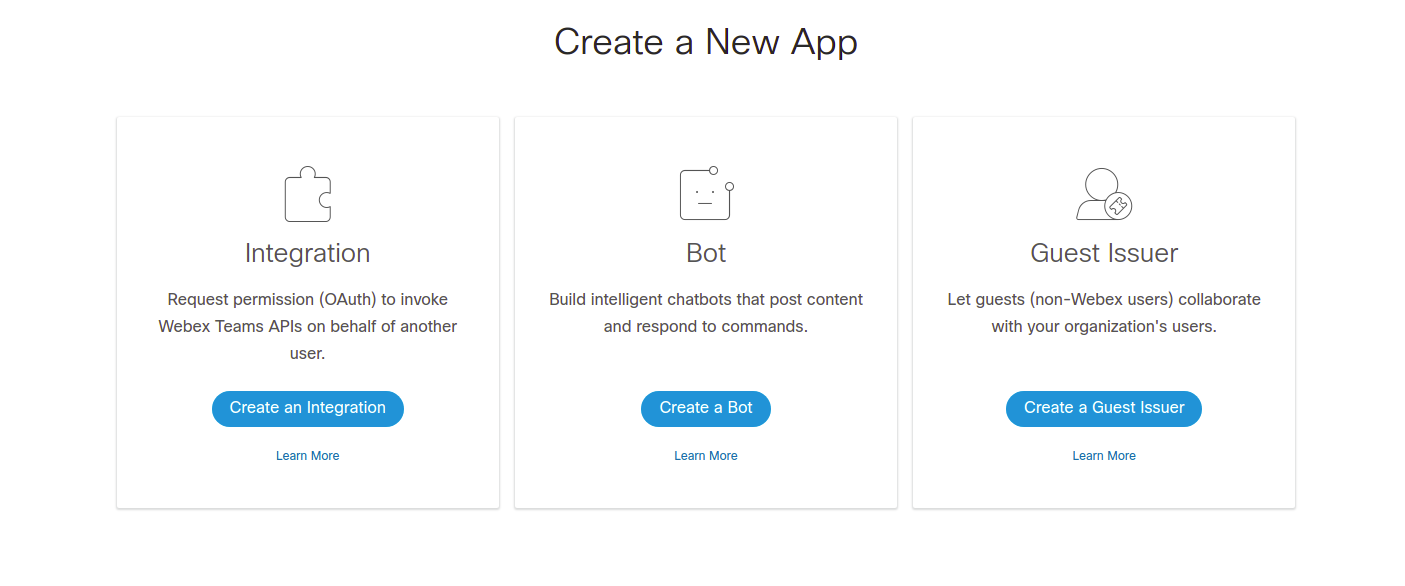

Select <b>No</b> for <b>Will this integration use a mobile SDK?</b> Give a good name to your Integration e.g. **MyWebex**  and provide your email address **e.g cholland@cbXXX.dcYY.com** . You can select any icon for your integration. In Description you can write anything as it is a test integration. Now the next thing is a "**redirect url**".

<div class="alert alert-block alert-info">
    <b>NOTE: </b> Please remember to replace XXX and YY with your session detail page 
</div>

### What is a redirect_url?
This is a url to which API will redirect the user once he/she has allowed the integration. This url is then appended by a unique code which is used for authentication (we will see later).

For now redirect_url can be anything (literally ANYTHING). For the sake of coherence, we will use https://www.hybridengineer.com

Now comes scope.

---
### What is a scope?
Scopes are permissions granted to your Integration.
For our purpose, just select **"spark:all".** This will give us permission to **read/write messages, rooms, and peoples.**

Browse at the bottom of the screen and **Click** on **"Add Integration".**

The next page will show you two main things: **Client ID** and **Client Secret**. Copy them some where safe as we will use them in our next steps.

## 2. Perform Authentication

Lets code

In [ ]:
client_id = ''  # Paste your client id here
redirect_uri = 'https://www.hybridengineer.com'
client_secret = ''  # Paste your client secret here
scopes = 'spark:all spark:kms'

So now the first step is to seek user's permission to allow your newly registered integration to access/modify your data. 
For this purpose we will send a post request to webex authorize endpoint and recieve a code for authentication.

In [ ]:
# we need the help from an external Python libraries
import urllib.parse
import uuid

# url on which we will send the request for authorization
base_url = 'https://webexapis.com/v1/authorize'

state = str(uuid.uuid4())   # some random UUID
print(f'State: {state}')

# prepare a dictionary with all parameters we need to encode in the URL
data = {
    'client_id' : client_id,
    'response_type' : 'code',  # Telling the API that we need the code
    'redirect_uri' : redirect_uri,
    'scope' : scopes,
    'state' : state
}

# this gets us a url encoded query string
query = urllib.parse.urlencode(data, quote_via=urllib.parse.quote)

print("Query" , query)

# .. which we then finally combine with the base url
url = f'{base_url}?{query}'
print('Click on following link to access code: ')
print(url)

**After** clicking on the link above, a new tab will open up. If prompted enter the credentials to allow access to integration. Press **Accept**

Now the client will redirect you to  "hybridengineer.com" i.e. our redirect_url. Note it also appends the code in front of the url. 

Copy the **COMPLETE URL** and paste it in the variable below called **last_redirect.**

<div class="alert alert-block alert-danger">
    Please ignore if you get Server Not Found error
</div>

<div class="alert alert-block alert-info">
    <b>Note:</b> The url might look something like this <b>Example:</b>
    https://www.hybridengineer.com/?code=NjQ4YzQ5YjktOGZiMC00YTdjLTljOTEtMjI5ZTE2NjI2ZTBjZTc0MGEyZWItMmYx_PE93_084497a9-c3c0-4d2c-863b-a5c9e6cc44e7&state=f0601673-e6d2-49c3-a8ba-e9b5a113af1e
</div>
    

In [ ]:
last_redirect = ''  # Paste the redirect link here 

# 1st we parse the URL. We are only interested in the query string parameters. We will be pulling the information for code & state
query = urllib.parse.urlparse(last_redirect).query


# then we parse the query string and get a dictionary with key/value pairs
query = urllib.parse.parse_qs(query)


# from that dictionary we finally extract the code
code = query['code'][0]
state = query['state'][0]

print(f'Code: {code}')
print(f'State (same as defined above in 2nd code block!): {state}')

Now the user has given permissions to our integration and we have got the **code**. The next thing we need is an **access token** that we can use to communicate with **Webex Teams API.** 

We can get an access token by sending a post request (along with code) to **"access_token"** endpoint.
<div class="alert alert-block alert-info">
    <b>Note:</b> Each code can be used to get only one access token. So if you need another access token, you have to regenerate the code.
</div>

In [ ]:
import requests
import json

access_token_url = 'https://webexapis.com/v1/access_token'

params = {
    'grant_type' : 'authorization_code',  # letting api know that we have authorization code
    'client_id' : client_id, # Defined Above
    'client_secret' : client_secret, # Defined Above
    'code' : code,  # the code we got from redirect_url
    'redirect_uri' : redirect_uri
}

# Sending request
r = requests.post(access_token_url, json = params).json()

print('JSON response:')
print(json.dumps(r, indent=4, sort_keys=True))

if r.get('errors'):
    error = r['errors'][0]
    print(f'Failed to get access token: {error["description"]}')
else:
    access_token = r['access_token']  # Our access token
    refresh_token = r['refresh_token']  # This token is explained later
    
    print(f'\nAccess token: {access_token}')
    print(f'Valid for {round(r["expires_in"] / 60 / 60 / 24)} days')
    print(f'\nRefresh token: {refresh_token}')
    print(f'Valid for {round(r["refresh_token_expires_in"] / 60 / 60 / 24)} days')

Valid for 14 days?? There is a specific validity limit for each access token. So the question is what to do after this span. This is where our refresh token comes. This refresh token can be used (within 90 days) to get another access token and refresh token.

## Develop Simple Application to send and recieve messages

Lets now try to use our **access token** to get  own stats

In [ ]:
url = 'https://webexapis.com/v1/people/me'

# authorization is achieved by passing the access token in an authorization header
headers = {'Authorization' : f'Bearer {access_token}',
          'Content-type' : 'application/json; charset=utf-8'}

r = requests.get(url, headers=headers)

print(json.dumps(r.json(), indent=4, sort_keys=True))

In the ouput above you can see all the information about your user incl. **Firstname, Lastname & Orgid.** 
Now lets list rooms so we know where we can send messages

Now lets create an API call to check if we have any rooms created between 2 users e.g. (for one-to-one messaging)

<div class="alert alert-block alert-info">
<b>Note:</b> In params below we will be sending type as 'direct' to check if any spaces are created between users
</div>

In [ ]:
url = 'https://webexapis.com/v1/rooms'  # This is the url for rooms api

params = {
    'max': 10,  # Max spaces to display
    'type' : 'direct'  # direct messages only i.e. one-to-one messaging
}

# authorization is achieved by passing the access token in an authorization header
headers = {'Authorization' : f'Bearer {access_token}',
          'Content-type' : 'application/json'}

r = requests.get(url, params=params, headers=headers)

# raise an exception in case the request failed
r.raise_for_status()

# use the json() method of the response object to get the response
print(json.dumps(r.json(), indent=4, sort_keys=True))

The oputput from the above will be empty as we dont have any one-to-one spaces created. 
> Lets now create a **Test Room** called **Omer API Room** where we can chat with ourselves and debug the application. Please feel free to create any room with a different title.

In [ ]:
url = 'https://webexapis.com/v1/rooms'  # This is the url for rooms api

params = {
    'title' : 'Omer API Room'  # This is the title of the room
}

# authorization is achieved by passing the access token in an authorization header
headers = {'Authorization' : f'Bearer {access_token}',
          'Content-type' : 'application/json; charset=utf-8'}

r = requests.post(url, json=params, headers=headers)

# raise an exception in case the request failed
r.raise_for_status()

# use the json() method of the response object to get the response
print(json.dumps(r.json(), indent=4, sort_keys=True))

Now we have created the room. If you log into your webex app, you will notice a new webex space is created. Please copy the **id** as we will be using going forward.
***
<div class="alert alert-block alert-info">
    <b>Note:</b> In the output above under <b>"type"</b> parameter, you can see it's created as  <b>"group"</b>. 
</div>
Now like above command , lets list  rooms so we can check our newly created room.

In [ ]:
url = 'https://webexapis.com/v1/rooms'  # This is the url for rooms api

params = {
    'max': 10,  # Max spaces to display
    'type' : 'group'  # Looking for room as type groups
}

# authorization is achieved by passing the access token in an authorization header
headers = {'Authorization' : f'Bearer {access_token}',
          'Content-type' : 'application/json; charset=utf-8'}

r = requests.get(url, params=params, headers=headers)

# raise an exception in case the request failed
r.raise_for_status()
spaces = r.json()['items']
# Lets search all group spaces for our Test Space
titles = [s['title'] for s in spaces]
print("Titles" , titles)
titles = [t for t in titles if 'Omer' in t] # Searching with Title of Omer if you have created a different room name please specify here
titles.sort()
title_details = [s for s in spaces if s['title'] in titles]

# use the json() method of the response object to get the response
print(json.dumps(title_details, indent=4, sort_keys=True))

You can see your space information. Copy the **id** as mentioned earlier. We will be using that to send a message to this space in next steps. But first lets see if there is any message already there 

In [ ]:
url = 'https://webexapis.com/v1/messages'
params = {
    'roomId' : '' # Replace it with your Room id (that you have created earlier) from above steps 
}

headers = {
    'Authorization' : f'Bearer {access_token}',
    'Content-Type' : 'application/json; charset=utf-8'
}
r = requests.get(url, params=params, headers=headers)

# use the json() method of the response object to get the response
print(json.dumps(r.json(), indent=4, sort_keys=True))

Gladly, there isn't any message there. So lets send one. 

In [ ]:
headers = {
    'Authorization' : f'Bearer {access_token}',
    'Content-Type' : 'application/json; charset=utf-8'
    }

params = {
    'roomId' : '', # Replace it with your Room id
    'text' : 'Hi All- Sending message via API call.'
}

url = 'https://webexapis.com/v1/messages'

r = requests.post(url, json=params, headers=headers)

# use the json() method of the response object to get the response
print(json.dumps(r.json(), indent=4, sort_keys=True))

You should be able to see the message , if you login into your webex app you will notice a message been recived in that space. 

<div class="alert alert-block alert-info">
    <b>NOTE:</b> As the message is been send you can also execute the code in previous function to list all the messages that are been sent
</div>

Lets create a function which will allow us to display and send messages.

In [ ]:
roomId = '' # Replace it with your Room id

def send_message(msg):
    
    headers = {
        'Authorization' : f'Bearer {access_token}',
        'Content-Type' : 'application/json; charset=utf-8'
        }

    params = {
          'roomId' : roomId,
          'text' : msg
      }

    url = 'https://webexapis.com/v1/messages'

    r = requests.post(url, json=params, headers=headers)
    
    params = {
        'roomId' : roomId
      }
    r = requests.get(url, params=params, headers=headers)

    r = r.json()
    
    print("omer" , r)

    for entry in r['items']:
        print(f"{entry['personEmail']} : {entry['text']}")

In [ ]:
send_message('Yes.')

<div class="alert alert-block alert-success">
    <b>Note:</b> The above method is for testing only.
</div>


<div class="alert alert-block alert-success">
    This conclude the section of the guide.
</div>


### REFERENCES -  APIs used in this notebook

<a href="https://developer.webex.com/docs/integrations">Understand Integrations</a>

<a href="https://developer.webex.com/docs/api/v1/people"> People API</a>

<a href="https://developer.webex.com/docs/api/v1/messages"> Messages API </a>

<a href="https://developer.webex.com/docs/api/v1/rooms/list-rooms"> Room API </a>